In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/03 PEMETAAN/01 MODEL - DRIVE

import os
# os.listdir()

/content/drive/MyDrive/03 PEMETAAN/01 MODEL - DRIVE


In [3]:
!pip install rioxarray
!pip install geopandas
!pip install tqdm
# !pip install google.cloud
!pip install configparser
!pip install optuna
!pip install catboost
!pip install pickle5
!pip install shap
!pip install geocube
!pip install fsspec
!pip install gcsfs

In [4]:
import pandas as pd
import numpy as np
from catboost import Pool, CatBoostClassifier
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import accuracy_score, f1_score,classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import pickle5 as pickle
from google.cloud import storage
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()

from bps_peta_processing import build_model,predict_train

import configparser
config = configparser.ConfigParser()
config.read('config/config_ecoregion_3001.ini')
folder=config['default']['folder']
train_no_outlier=config['output']['train_data_no_outlier']
model_param_feature=config['output']['model_param_feature']
model_learn=config['output']['model_learn']

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning:

The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.



In [5]:
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'petabps-7c4331c6fd2d.json'

## Load the Data

Load the data training

In [6]:
file_name='kerangka-spasial/ml_learning/train_data/'+train_no_outlier
data_=pd.read_csv(file_name,sep=';')

## Load Model Parameter and Feature Selection
Load the model parameter and feature selection from pickle that previously uploaded to Google Cloud

In [7]:
with open('kerangka-spasial/ml_learning/model_result/'+model_param_feature, 'rb') as f:
    dict_model = pickle.load(f)

In [8]:
dict_model

{'features': ['PODES_landform',
  'alos_slope',
  'alos_dsm',
  'wet_mean',
  'green_mean',
  'bright_mean',
  'ARVI_mean',
  'SAVI_mean',
  'NDBI_mean',
  'mNDWI_mean',
  'NDWI_mean',
  'NDVI_mean',
  'wet_p50',
  'green_p50',
  'bright_p50',
  'ARVI_p50',
  'SAVI_p50',
  'NDBI_p50',
  'mNDWI_p50',
  'NDWI_p50',
  'mNDVI_p50',
  'NDVI_p50',
  'S2_B12mean',
  'S2_B11mean',
  'S2_B8mean',
  'S2_B4mean',
  'S2_B3mean',
  'S2_B2mean',
  'S2_B12med',
  'S2_B11med',
  'S2_B8med',
  'S2_B4med',
  'S2_B3med',
  'S2_B2med'],
 'params': {'auto_class_weights': 'SqrtBalanced',
  'boosting_type': 'Plain',
  'bootstrap_type': 'MVS',
  'colsample_bylevel': 0.08177007704536694,
  'depth': 14,
  'l2_leaf_reg': 0.0009254053135587522,
  'learning_rate': 0.0464976478120535}}

## Building Model

Build the model

In [9]:
X=data_[dict_model['features']]
y=data_[['TRAIN_CLASS']]
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2,stratify=y)
sk_fold=StratifiedKFold(n_splits=7,shuffle=False)

In [10]:
dict_model['params']['iterations']=150
dict_model['params']["used_ram_limit"]="10gb"
dict_model['params']["random_seed"]=1234

In [11]:
cat_model,f1_=build_model(dict_model,train_x,valid_x,train_y,valid_y,sk_fold)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [12]:
print('F1-score test: ', np.mean(f1_))

F1-score test:  0.9904551242135003


## Do prediction

Do prediction of valid instances and produce the summary of classification

CLASSIFICATION SUMMARY:
ACCURACY : 0.9905666514865656
F1-micro score : 0.9905666514865656
F1-macro score : 0.9822399389071167
              precision    recall  f1-score   support

           1       0.98      1.00      0.99      1364
           2       1.00      0.99      1.00       663
           4       0.96      0.94      0.95       152
           5       0.99      0.98      0.98      2994
           6       1.00      1.00      1.00        26
           7       0.87      0.94      0.91       297
           9       1.00      0.99      1.00      1369
          10       0.99      0.98      0.98       483
          11       1.00      1.00      1.00      4182
          12       0.99      1.00      1.00      1459
          31       0.99      1.00      1.00      1373
          33       0.99      1.00      0.99      1009

    accuracy                           0.99     15371
   macro avg       0.98      0.98      0.98     15371
weighted avg       0.99      0.99      0.99     15371



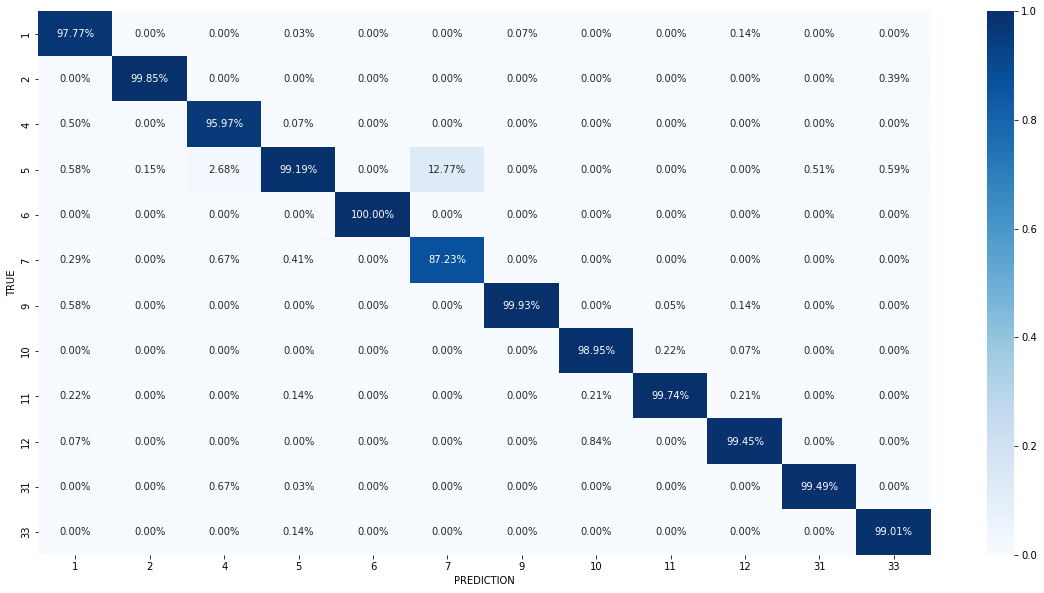

In [13]:
predict_train(valid_x,valid_y,cat_model,dict_model['features'])

## Explain Classification Model

Explain the model using SHAP value

In [ ]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(valid_x)

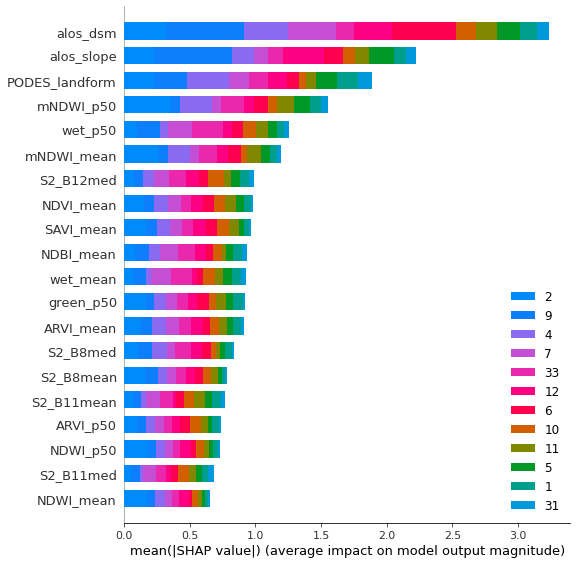

In [ ]:
class_names=valid_y.TRAIN_CLASS.unique()
shap.summary_plot(shap_values, valid_x.values, plot_type="bar", class_names= class_names, 
                  feature_names = valid_x.columns)

CLASS NAMES
[ 7  5  9 31  2  1  4 11 33 10  6 12]


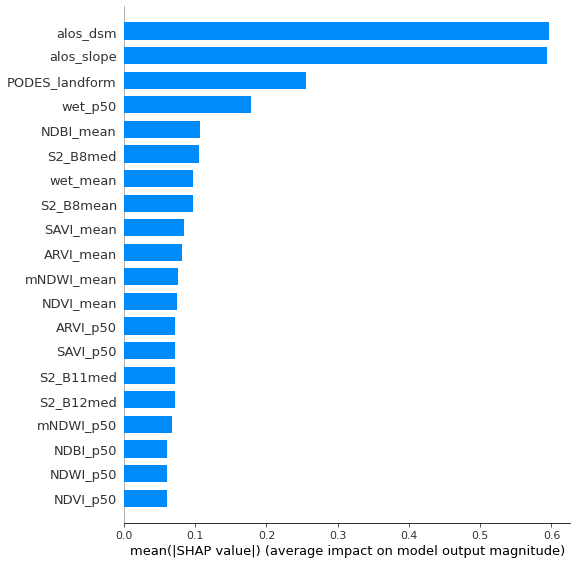

In [ ]:
class_names=y.TRAIN_CLASS.unique()
print('CLASS NAMES')
print(class_names)
shap.summary_plot(shap_values[3], valid_x.values, plot_type="bar", class_names= class_names, 
                  feature_names = valid_x.columns)

In [ ]:
print('SHAP SUMMARY PLOT')
shap.summary_plot(shap_values[3], valid_x)

In [ ]:
print(valid_x.iloc[100])
print(valid_y.iloc[100])

In [ ]:
row=100
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                    base_values=explainer.expected_value[0], data=valid_x.iloc[row],  
                                    feature_names=valid_x.columns.tolist()))

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0][row], valid_x.values[row], 
                feature_names = valid_x.columns)

## Export model to Cloud

In [ ]:
with open(model_learn, 'wb') as handle:
    pickle.dump(cat_model, handle, protocol=pickle.HIGHEST_PROTOCOL)